Assess percent of wells tested using a grid 

Creates a narrowed down list of wells that have yet to be tested, but are within a certain range of a well that has been tested. Per the results of flanagan et al (2020) targeteting wells that are within 1.5 km of a well that has shown elevated arsenic levels is a more efficient use of resources than targeting all wells in a larger area as seen on Gaston Water Map. While the water map outlines the broader area where elevated resutls are present, the clustering of arsenic appears to be much more localized within the outlined risk area.

In [ ]:
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fiona as fio
import shapely as shp  
import math
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

In [ ]:
# Read in all wells csv files

wells_all = pd.read_csv('../data/csv/permitted_wells_cleaned.csv')

# convert to geodataframe

wells_all = gpd.GeoDataFrame(wells_all, geometry=gpd.points_from_xy(wells_all.X, wells_all.Y, crs='EPSG:4269'))
wells_ar = gpd.read_file('../data/gis/point/ar_samples_w_covariates.geojson')
cnty = gpd.read_file('../data/gis/polygon/county_gaston.geojson')

print(wells_ar.crs)
print(cnty.crs)

EPSG:4269
EPSG:4269


In [162]:
wells_elev = wells_ar[wells_ar['group_five'] == 1]


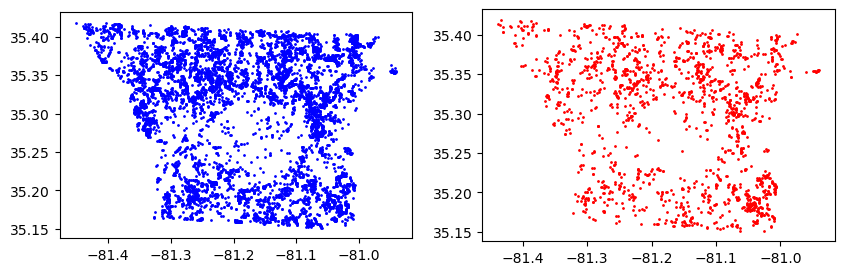

In [163]:

# plot the two geo dataframes in the same plot same row

fig, ax = plt.subplots(1,2, figsize=(10,5))
wells_all.plot(ax=ax[0], color='blue', markersize=1)
wells_ar.plot(ax=ax[1], color='red', markersize=1)
plt.show()

In [164]:
# convert both geodataframes to projected coordinate system for network analysis

wells_all = wells_all.to_crs('EPSG:32617')
wells_ar = wells_ar.to_crs('EPSG:32617')
cnty = cnty.to_crs('EPSG:32617')

# create a blank polygon grid polygon that's the shape of a county geojson polygon, 
# where each grid is 1 mile by 1 mile

# Function to create a polygon grid
def create_polygon_grid(county_polygon, grid_size):
    xmin, ymin, xmax, ymax = county_polygon.bounds

    rows = int(np.ceil((ymax - ymin) / grid_size))
    cols = int(np.ceil((xmax - xmin) / grid_size))

    grid_polygons = []
    for i in range(cols):
        for j in range(rows):
            x1 = xmin + i * grid_size
            x2 = xmin + (i + 1) * grid_size
            y1 = ymin + j * grid_size
            y2 = ymin + (j + 1) * grid_size
            grid_polygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))

    return MultiPolygon(grid_polygons)


# Get the county polygon (assuming only one polygon in the GeoJSON file)
county_polygon = cnty.iloc[0].geometry


In [165]:

# Create a 250m grid within the county polygon
grid_size_meters = 1000
grid = create_polygon_grid(county_polygon, grid_size_meters)

# Filter the grid cells that are within the county polygon
grid_within_county = [poly for poly in grid.geoms if poly.intersects(county_polygon)]

# Create a GeoDataFrame from the grid cells and save it to a new GeoJSON file
grid_gdf = gpd.GeoDataFrame({"geometry": grid_within_county}, crs=cnty.crs)
grid_gdf.to_file("../data/gis/polygon/county_grid.geojson", driver="GeoJSON")



In [166]:
len(grid_gdf)

1032

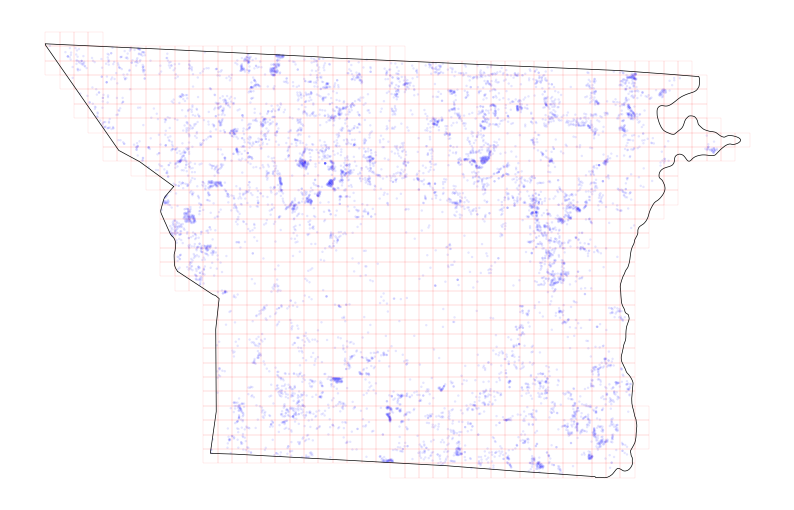

In [208]:
f, ax = plt.subplots(1, figsize=(10, 10))


wells_all.plot(
    color="blue",
    edgecolor="none",
    alpha=0.1,
    markersize=3,
    ax=ax,
)

grid_gdf.plot(
    color="none",
    edgecolor="red",
    linewidth=0.1,
    alpha=0.5,
    ax=ax,
)
cnty.plot(
    color="none",
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)
#contextily.add_basemap(
#    ax,
#    crs=detect.crs,
#    source=contextily.providers.Stamen.Terrain,
#)
ax.set_axis_off()

In [168]:
# for each grid cell, count the number of points from the 'all_wells' geodataframe that are within the grid cell
# and add that count to a new column in the grid geodataframe

grid_gdf['count_wells'] = grid_gdf.apply(lambda row: len(wells_all[wells_all.within(row.geometry)]), axis=1)

# count the number of wells sampled in each grid cell

grid_gdf['count_samples'] = grid_gdf.apply(lambda row: len(wells_ar[wells_ar.within(row.geometry)]), axis=1)

# count whether the grid cell contains any wells that have a 'group_five' value of 1

grid_gdf['elevated'] = grid_gdf.apply(lambda row: len(wells_ar[(wells_ar.within(row.geometry)) & (wells_ar['group_five'] == 1)]), axis=1)


In [169]:
print("Total grid cells: ", len(grid_gdf))
print("Grid cells with wells: ", len(grid_gdf[grid_gdf['count_wells'] > 0]))
print("Grid cells with samples: ", len(grid_gdf[grid_gdf['count_samples'] > 0]))

Total grid cells:  1032
Grid cells with wells:  825
Grid cells with samples:  570


In [205]:


# calculate the ratio of wells sampled to wells permitted as a percentage in a new column
# first drop any features where there are less than 5 wells permitted

grid_samples = grid_gdf[grid_gdf['count_wells'] > 5]

grid_samples['ratio'] = grid_samples['count_samples'] / grid_samples['count_wells'] * 100

# remove any grid cells where the ratio is GT 100% 
# (i.e. anomolies in geocoding in the grid cell having more samples than permitted wells)
# since this will mess up the color scale of the mapping

grid_samples = grid_samples[grid_samples['ratio'] <= 100]

# clip grid samples to county

grid_samples = gpd.clip(grid_samples, cnty)

c:\Users\kendall\miniconda3\envs\pygis\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [206]:
print(grid_samples.crs)
print(cnty.crs)
print(wells_elev.crs)


EPSG:32617
EPSG:32617
EPSG:32617


In [198]:
wells_elev = wells_elev.to_crs('EPSG:32617')

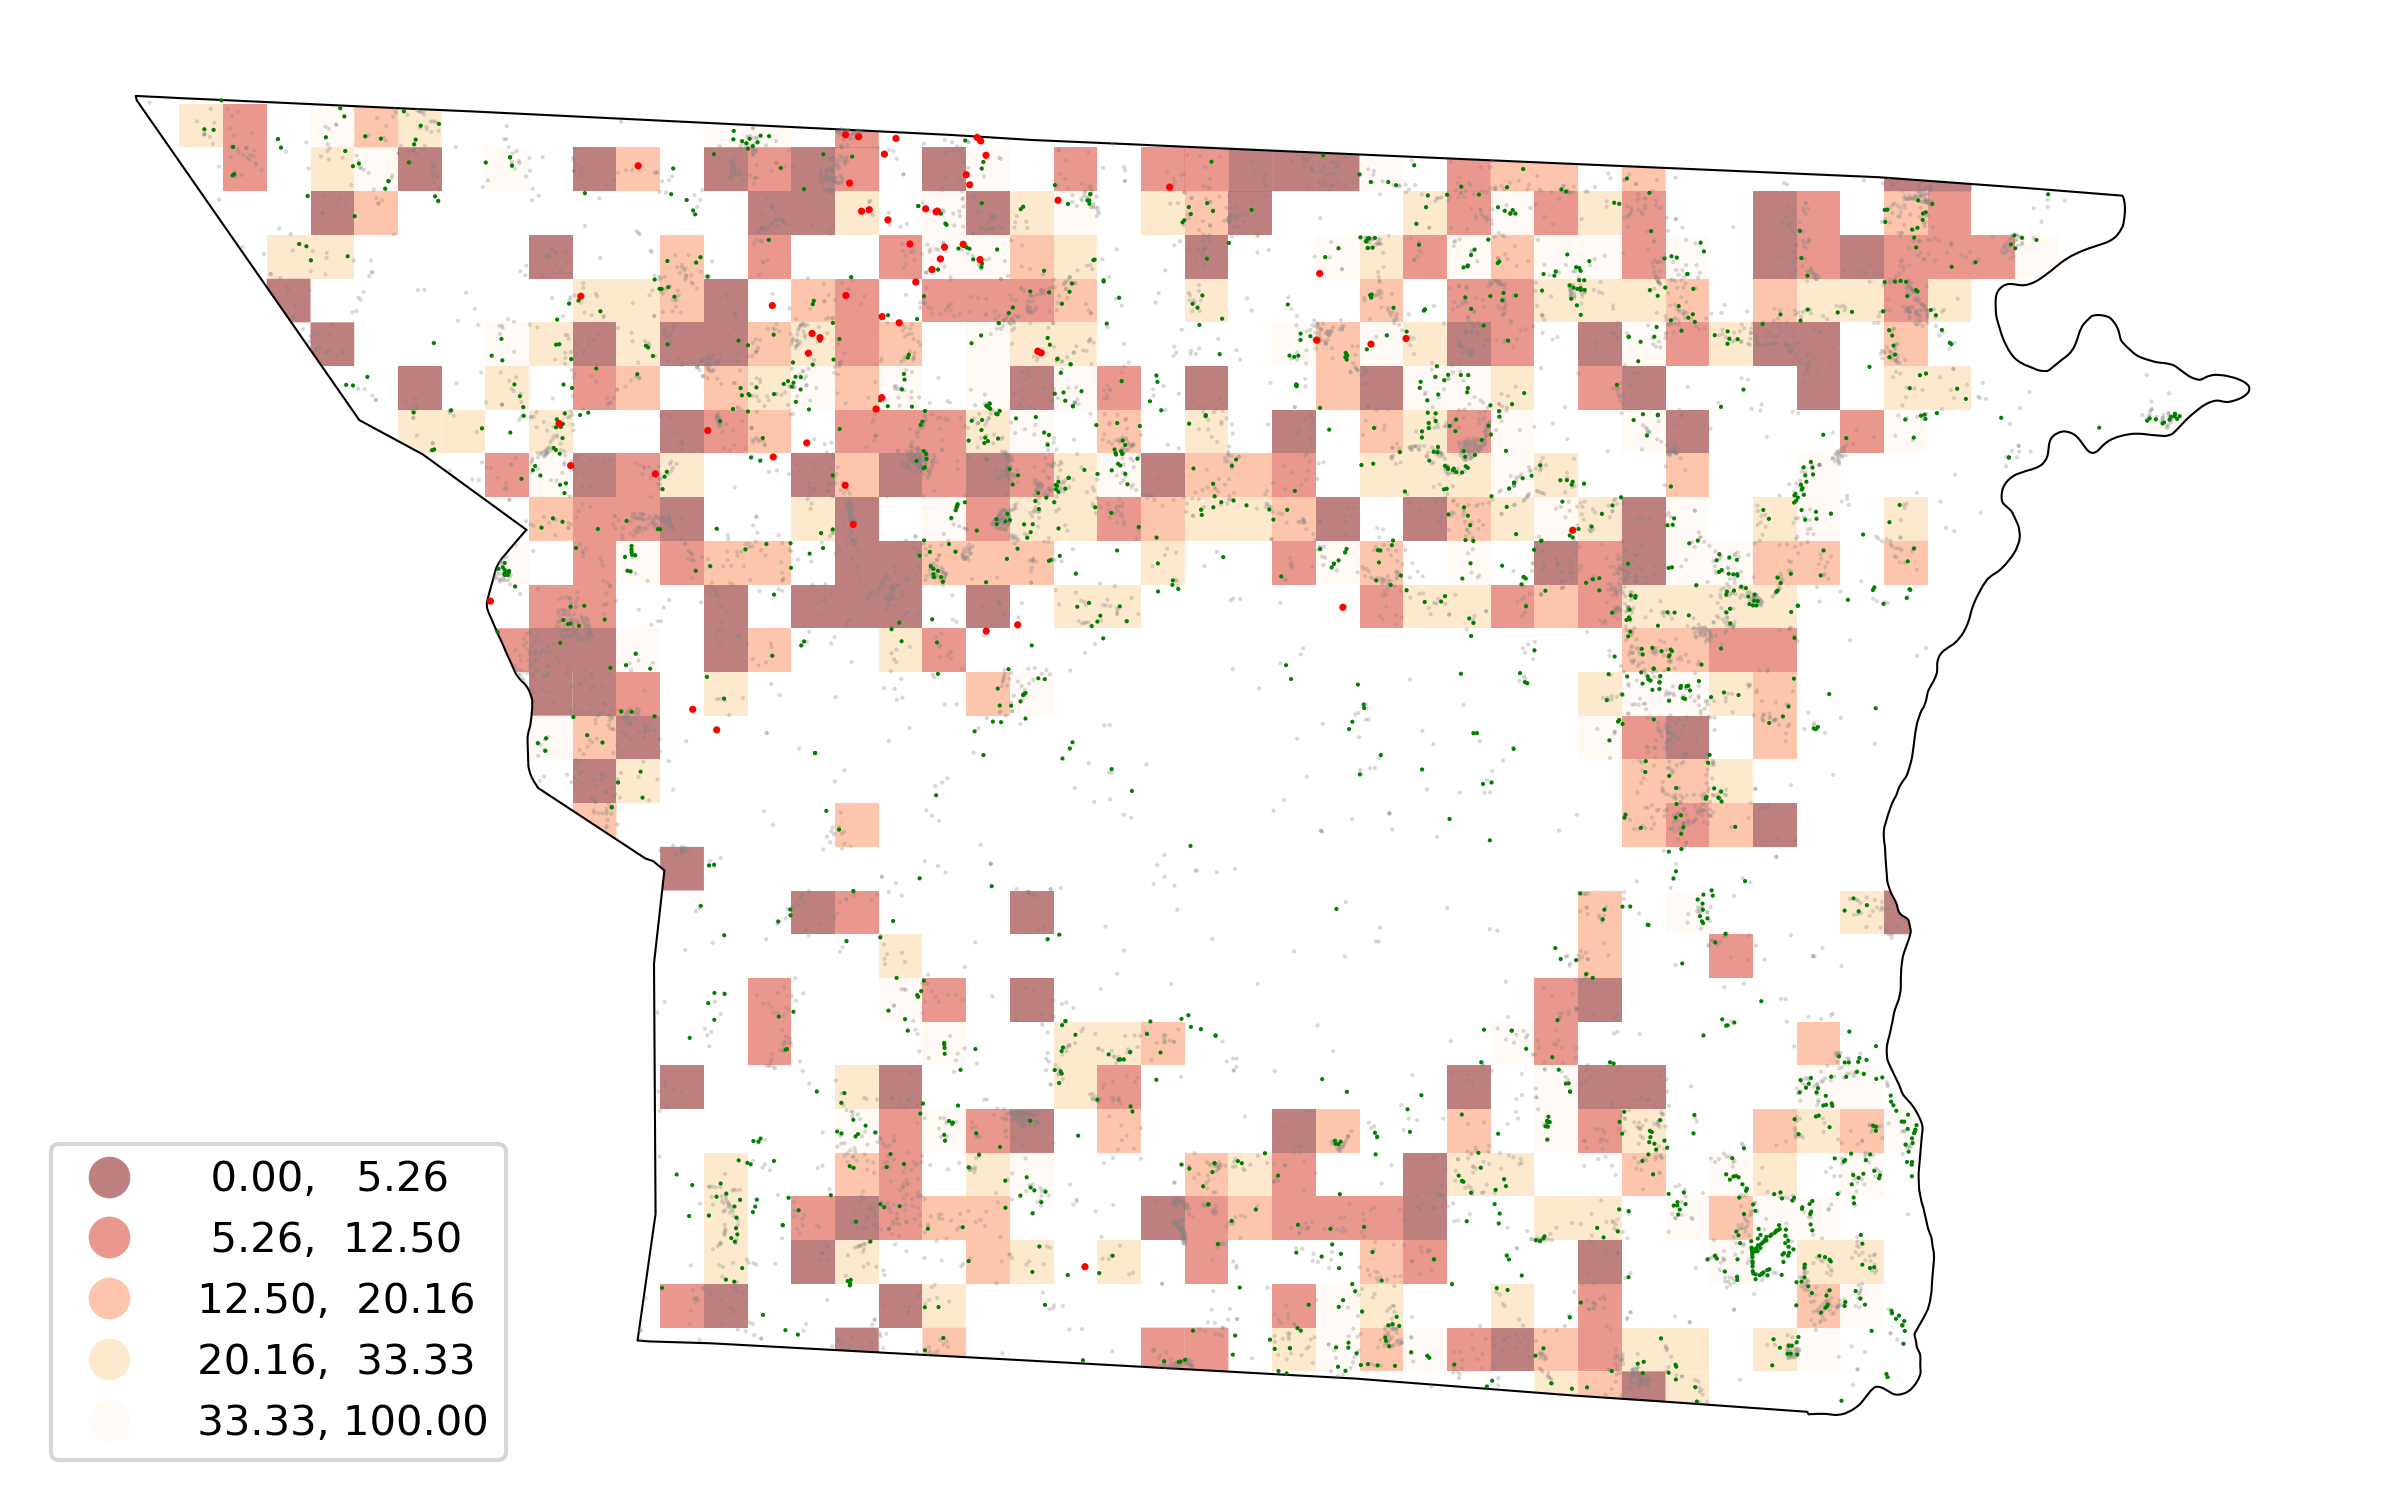

In [ ]:
# map the grid_samples geodataframe to show the ratio of wells sampled to wells permitted
# using cloropleth map

f, ax = plt.subplots(1, figsize=(10, 10), dpi=300)

grid_samples.plot(
    column="ratio",
    cmap="OrRd_r",
    edgecolor="none",
    alpha=0.3,
    scheme='quantiles',
    ax=ax,
    legend=True
)
cnty.plot(
    color="none",
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)

wells_all.plot(
    color="grey",
    edgecolor="none",
    alpha=0.3,
    markersize=1,
    ax=ax,
)

wells_ar.plot(
    color="green",
    edgecolor="none",
    markersize=1,
    ax=ax
)

wells_elev.plot(
    color="pink",
    edgecolor="none",
    markersize=5,
    ax=ax,
    legend=True
)

#contextily.add_basemap(
#    ax,
#    crs=detect.crs,
#    source=contextily.providers.Stamen.Terrain,
#)
ax.set_axis_off()



In [209]:
# subset the grid geodataframe to only include grid cells with an elevated sample 

grid_elevated = grid_gdf[grid_gdf['elevated'] > 0]

# remove the wells that have been sampled from the all wells dataframe

wells_unsampled = wells_all[~wells_all['id'].isin(wells_ar['id'])]
len(wells_unsampled)


# assign the ratio of wells sampled to wells permitted in the grid cell to each well in the wells_unsampled dataframe

wells_unsampled['ratio'] = wells_unsampled.apply(lambda row: grid_samples[grid_samples.geometry.contains(row.geometry)]['ratio'].values, axis=1)
wells_unsampled['ratio'] = wells_unsampled['ratio'].apply(lambda x: x[0] if len(x) > 0 else None)

# add an indicator in the wells_unsampled dataframe to identify cells within the grid cells with elevated samples

wells_unsampled['elevated'] = wells_unsampled.apply(lambda row: grid_elevated[grid_elevated.geometry.contains(row.geometry)]['elevated'].values, axis=1)
wells_unsampled['elevated'] = wells_unsampled['elevated'].apply(lambda x: x[0] if len(x) > 0 else None)

In [219]:
print(F'''Number of Unsampled wells
    {len(wells_unsampled)}''')

print(F'''Number of Unsampled wells
where the overall testing rate is less than than 50%
    {len(wells_unsampled[wells_unsampled['ratio'] < 50])}''')

print(F'''Number of Unsampled wells
where the overall testing rate is less than than 25%
    {len(wells_unsampled[wells_unsampled['ratio'] < 25])}''')

print(f'''Number of Unsampled wells 
where the overall testing rate is less than 10%
    {len(wells_unsampled[wells_unsampled['ratio'] < 10])}''')

print(f'''Number of Unsampled wells 
where the overall testing rate is less than 5%
    {len(wells_unsampled[wells_unsampled['ratio'] < 5])}''')

print(f'''Number of Unsampled wells 
where the overall testing rate is 0
    {len(wells_unsampled[wells_unsampled['ratio'] < 5])}''')

Number of Unsampled wells
    8133
Number of Unsampled wells
where the overall testing rate is less than than 50%
    6650
Number of Unsampled wells
where the overall testing rate is less than than 25%
    5021
Number of Unsampled wells 
where the overall testing rate is less than 10%
    2420
Number of Unsampled wells 
where the overall testing rate is less than 5%
    1371
Number of Unsampled wells 
where the overall testing rate is 0
    1371


In [218]:

# check the length of the wells_unsampled dataframe to make sure it's less than the original dataframe

print(f'''Number of unsampled wells in a cell with an elevated sample
    {len(wells_unsampled[(wells_unsampled['elevated'] == 1)])}''')

print(f'''Number of Unsampled wells in a cell with an elevated sample, 
where the overall testing rate is less than 50%
    {len(wells_unsampled[(wells_unsampled['ratio'] < 50) & (wells_unsampled['elevated'] == 1)])}''')

print(f'''Number of Unsampled wells in a cell with an elevated sample, 
where the overall testing rate is less than 25%
    {len(wells_unsampled[(wells_unsampled['ratio'] < 25) & (wells_unsampled['elevated'] == 1)])}''')

print(f'''Number of Unsampled wells in a cell with an elevated sample, 
where the overall testing rate is less than 10%
    {len(wells_unsampled[(wells_unsampled['ratio'] < 10) & (wells_unsampled['elevated'] == 1)])}''')

print(f'''Number of Unsampled wells in a cell with an elevated sample, 
where the overall testing rate is less than 5%
    {len(wells_unsampled[(wells_unsampled['ratio'] < 5) & (wells_unsampled['elevated'] == 1)])}''')

Number of unsampled wells in a cell with an elevated sample
    393
Number of Unsampled wells in a cell with an elevated sample, 
where the overall testing rate is less than 50%
    322
Number of Unsampled wells in a cell with an elevated sample, 
where the overall testing rate is less than 25%
    211
Number of Unsampled wells in a cell with an elevated sample, 
where the overall testing rate is less than 10%
    110
Number of Unsampled wells in a cell with an elevated sample, 
where the overall testing rate is less than 5%
    33


In [221]:
# create a loop where a priority number is set to each unsampled well, based on the ratio of wells sampled to wells permitted
# and the presence of an elevated sample in the grid cell

li = []

for index, row in wells_unsampled.iterrows():
    priority = 0
    if row['ratio'] < 5 and row['elevated'] == 1:
        priority = 1
    elif row['ratio'] < 10 and row['elevated'] == 1:
        priority = 2
    elif row['ratio'] < 25 and row['elevated'] == 1:
        priority = 3
    elif row['ratio'] < 50 and row['elevated'] == 1:
        priority = 4
    elif row['ratio'] < 5:
        priority = 5

    li.append(priority)

wells_unsampled['priority'] = li



In [223]:
wells_unsampled['priority'].value_counts()

priority
0    6473
5    1338
4     111
3     101
2      77
1      33
Name: count, dtype: int64

In [227]:
# write to a csv file

wells_unsampled.to_csv('../data/csv/wells_needing_testing.csv', index=False)